# Replication: Zeighami *et al*, 2019

## Introduction

This notebook attempts to reproduce the following paper (which already uses the [PPMI](http://ppmi-info.org) dataset):

<div class="alert alert-block alert-success">
Zeighami, Yashar, et al. <a href=https://doi.org/10.1016/j.nicl.2019.101986>Assessment of a prognostic MRI biomarker in early de novo Parkinson's disease.</a> NeuroImage: Clinical 24 (2019): 101986.
</div>

This study used longitudinal MRI data from 362 patients with de novo PD (i.e., patients not yet taking any medication) and 112 healthy controls. Subjects were split into a main cohort with 3T MRI scans (222 PD patients, 112 healthy controls) and a validation cohort with 1.5T MRI scans (140 PD patients). 

The demographics parameters for the PD patients were as follows (table extracted from the paper):

<img src="images/demographics.png" width=800/>

This paper used a method introduced in [Zeighami *et al* (2015)](https://doi.org/10.7554/eLife.08440) consisting of applying Independent Component Analysis (ICA) to Deformation-Based Morphometry (DBM) maps to identify an atrophy network related to PD. The main result is atrophy measures from this PD network is significantly correlated with disease progression as measured by differences in clinical and/or cognitive scores between the baseline visit and the most recent follow-up visit. This is illustrated in the top row of the following table (extracted from the paper):

<img src="images/results_correlations.png" width=600/>

The authors also showed that the PD-related atrophy score can be used to identify patients who have a 1.5 standard deviation change in the global composite outcome (a measure they defined) between baseline and follow-up visits. The PD-related atrophy biomarker achieved an area under the receiver operating characteristics (ROC) curve of 0.63, out-performing other biomarkers, as shown in the figure below (extracted from the paper):

<img src="images/results_AUC.png" width=500/>

The remainder of this notebook is an attempt to reproduce these results using the same PPMI dataset.

## Initial setup

We first initialize the notebook cache and install dependencies:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()

This notebook was run on 2023-04-08 05:57:33 UTC +0000


We import required libraries/functions and load some useful constants and helper functions from the `zeighamietal` module of `livingpark_utils`. The code used to create the initial cohorts based on T1 data availability is reused in another notebook.  

In [2]:
import os
import re
from functools import reduce
from pathlib import Path

import numpy as np
import pandas as pd

from livingpark_utils.download import ppmi

from livingpark_utils.zeighamietal.constants import (
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_DEMOGRAPHICS,
    FILENAME_PD_HISTORY,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_ADL,
    FILENAME_T1_INFO,
)

from livingpark_utils.zeighamietal.constants import (
    COL_PAT_ID,
    COL_STATUS,
    COL_VISIT_TYPE,
    COL_DATE_INFO,
    COL_DATE_BIRTH,
    COL_DATE_PD,
)

from livingpark_utils.zeighamietal.constants import (
    STATUS_PD,
    STATUS_HC,
    MAIN_COHORT,
    VALIDATION_COHORT,
    VISIT_BASELINE,
    VISIT_SCREENING,
    REGEX_VISIT_FOLLOWUP,
    SEX_MALE,
    MAX_DATES,
)

from livingpark_utils.zeighamietal.constants import (
    COL_AGE,
    COL_PD_STATE,
    COL_SEX,
    COL_UPDRS1A,
    COL_UPDRS1B,
    COL_UPDRS2,
    COL_UPDRS3,
    COL_MOCA,
    COL_ADL,
    COL_UPDRS1,
    COL_PIGD,
    COL_GCO,
    COLS_PIGD_COMPONENTS_UPDRS2,
    COLS_PIGD_COMPONENTS_UPDRS3,
    COLS_PIGD_COMPONENTS,
    COLS_SCORES_WITHOUT_GCO,
    COL_FOLLOWUP,
)

from livingpark_utils.zeighamietal import (
    load_ppmi_csv,
    get_t1_cohort,
    mean_impute,
    filter_date,
)

## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as closely as possible. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 

* Participant status (Parkinson's disease, healthy control, etc.)
* Demographics
* Age at visit
* Clinical/cognitive assessment results:
    * Montreal Cognitive Assessment (MoCA)
    * Unified Parkinson's Disease Rating Scale (UPDRS) Parts I, II and III
    * Modified Schwab and England Activities of Daily Living scale

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, a PPMI username and password are required to obtain the files. New PPMI accounts can be requested [here](http://ppmi-info.org).

In [3]:
required_files = [
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_PD_HISTORY,
    FILENAME_DEMOGRAPHICS,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_ADL,
]

downloader = ppmi.Downloader(utils.study_files_dir)
utils.get_study_files(required_files, default=downloader)

Download skipped: No missing files!


### Subjects with T1 MRI available

The paper uses a main cohort and a validation cohort. The **main cohort** consists of subjects with 3T T1 scans and is a subset of the cohort the authors used in the 2015 paper. The **validation cohort** consists of subjects with 1.5T T1 scans.

***Main cohort***

The main cohort was made up of of 222 PD patients and 112 healthy controls. In the 2015 paper, the authors used data from 237 PD patients and 118 healthy controls. MRI processing failure led to the exclusion of 5 PD patients and 1 healthy control, and so the final cohort consisted of 232 PD patients and 117 healthy controls. In the 2019 paper, an additional 10 PD patients and 5 healthy controls were excluded due to lack of follow-up data required in the analysis.

*Note*: In the 2015 paper, the authors state that they used scans acquired from September 2013 to January 2014. However, if we restrict our search to this time period, the number of available scans is much lower than expected (38 PD patients instead of 237, 1 healthy control instead of 118). If we instead use all subjects with 3T scans from January 31st 2014 and before, we obtain 236 PD patients and 113 healthy controls, which is closer to what we expect thought still not exactly the same.

***Validation cohort***

The validation cohort was made up of 140 PD patients. The paper states that data were downloaded in October 2017, so we use all subjects with 1.5T scans from October 31st 2017 and before. 

In [4]:
from livingpark_utils.scripts import mri_metadata

df_status = load_ppmi_csv(utils, FILENAME_PARTICIPANT_STATUS)

df_t1_info = get_t1_cohort(
    utils,
    cohort_name=MAIN_COHORT,
    filename=FILENAME_T1_INFO,
    sagittal_only=True,
)

print(df_t1_info.drop_duplicates(COL_PAT_ID)[COL_STATUS].value_counts())

This notebook was run on 2023-04-08 05:57:33 UTC +0000
['COR', 'Coronal', 'Cal Head 24', 'Transverse', 'tra_T1_MPRAGE', 'TRA']
['AX', 'Ax', 'axial', 'Phantom', 'T2']
{'Screening': 'SC', 'Baseline': 'BL', 'Month 6': 'V02', 'Month 12': 'V04', 'Month 24': 'V06', 'Month 36': 'V08', 'Month 48': 'V10', 'Symptomatic Therapy': 'ST', 'Unscheduled Visit 01': 'U01', 'Unscheduled Visit 02': 'U02', 'Premature Withdrawal': 'PW'}
Saved in MRI_info.csv
Using MRI info file: /data/origami/livingpark/zeighami-etal-2019/inputs/study_files/MRI_info.csv
Parkinson's Disease    244
Healthy Control        117
Name: COHORT_DEFINITION, dtype: int64


In [5]:
# get cohort ID
cohort_id = livingpark_utils.dataset.ppmi.cohort_id(
    df_t1_info.drop_duplicates(COL_PAT_ID)
)
print(f"Cohort id: {cohort_id}")

# save subject ids
fpath_cohort = Path("dbm", f"zeighami-etal-2019-cohort-{cohort_id}.csv")
df_t1_info.drop_duplicates().sort_values(by=COL_PAT_ID).to_csv(
    fpath_cohort, index=False
)
print(f"\tCohort patient ids saved in {fpath_cohort}")

print("Do not share this file publicly!")

Cohort id: 5461037918345710153
	Cohort patient ids saved in dbm/zeighami-etal-2019-cohort-5461037918345710153.csv
Do not share this file publicly!


## MRI data processing

TODO Description of how to run DBM on BIC

### Download DBM results from BIC server

In [6]:
# TODO

### Run ICA using FSL MELODIC

In [7]:
# TODO

## PD-ICA component

In [8]:
# TODO change
tag = '_460520092359662532_qc1'
melodic_method = 'lap'
dpath_tarballs = '/data/origami/livingpark/zeighami-etal-2019/dbm/tarballs'
fpath_melodic = Path(dpath_tarballs, f'melodic_results-{tag}-{melodic_method}')
fpath_scores = Path(fpath_melodic, 'melodic_Tmodes')
fpath_ICs = Path(fpath_melodic, 'melodic_IC.nii.gz')
fpath_info = Path(dpath_tarballs, f'tmp-{tag}', 'info.csv')

In [9]:
df_scores = pd.read_csv(fpath_scores, delim_whitespace=True, header=None)
subjects = pd.read_csv(fpath_info)['subject'].to_list()

df_scores.columns = [f'IC{i+1}' for i in range(df_scores.shape[1])]
df_scores.index = subjects

df_scores_status = df_scores.copy() # show status instead of ID
df_scores_status.index = df_status.set_index(COL_PAT_ID).loc[subjects, COL_STATUS].reset_index(drop=True)

print(f'{df_scores_status.shape[1]} ICs')
print(f'{df_scores_status.shape[0]} participants:')
print(df_scores_status.index.value_counts())

31 ICs
354 participants:
Parkinson's Disease    238
Healthy Control        116
Name: COHORT_DEFINITION, dtype: int64


In [10]:
import numpy as np
from scipy.stats import ttest_ind

p_values = pd.Series(
    ttest_ind(
        df_scores_status.loc["Parkinson's Disease"],
        df_scores_status.loc["Healthy Control"],
        alternative='less',
    )[1],
    index=df_scores_status.columns.to_list()
)

i_components_sorted = np.argsort(list(p_values))
p_values *= len(p_values) # Bonferroni correction

print(p_values.sort_values())

IC9      0.012803
IC10     0.949017
IC27     1.244832
IC7      1.917394
IC19     2.177640
IC16     2.443229
IC8      2.621142
IC31     4.289025
IC3      4.443680
IC6      6.518653
IC12     7.685009
IC26     8.566268
IC29     9.151588
IC18    11.022191
IC15    11.433351
IC5     11.918975
IC11    13.617587
IC20    14.781187
IC25    16.338769
IC22    16.890953
IC17    20.949272
IC4     20.977539
IC30    23.905324
IC13    24.048246
IC1     25.978389
IC2     26.688715
IC23    27.053452
IC24    28.058071
IC21    28.242724
IC14    28.561560
IC28    29.543446
dtype: float64


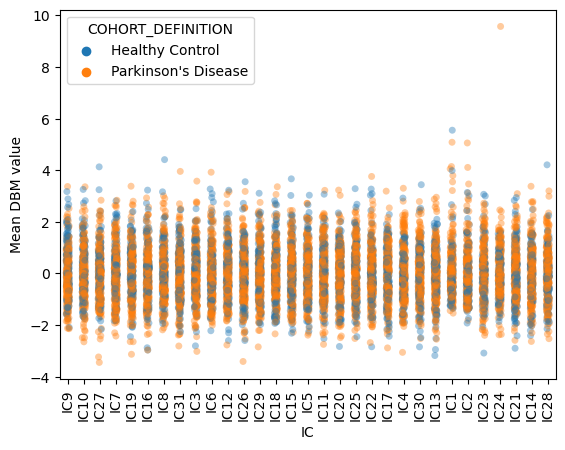

In [11]:
import seaborn as sns

x_label = "IC"
y_label = "Mean DBM value"

df_scores_to_plot = pd.melt(
    df_scores_status.reset_index(),
    id_vars=[COL_STATUS],
    var_name=x_label,
    value_name=y_label,
)

ax = sns.stripplot(
    df_scores_to_plot,
    x=x_label,
    y=y_label,
    hue=COL_STATUS,
    order=p_values.sort_values().index,
    alpha=0.4,
)
ax.tick_params(axis="x", rotation=90)



<Axes: xlabel='IC9', ylabel='Count'>

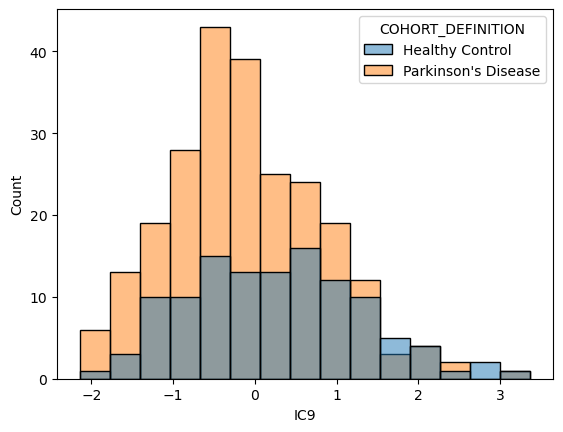

In [12]:
sns.histplot(
    df_scores_status.reset_index(),
    x='IC9',
    hue=COL_STATUS,
)

In [13]:
from nilearn import image, plotting
import nibabel as nib


def plot_IC(fpath, i_component=None, threshold=2.5, display_mode="z", cut_coords=None, title=None):
    img = nib.load(fpath)
    if i_component is not None:
        img = image.index_img(img, i_component)
    display = plotting.plot_stat_map(
        img, threshold=threshold, display_mode=display_mode, cut_coords=cut_coords, title=title,
    )
    return display

In [14]:
%%bash
FNAME_PD_ICA="melodic_IC_0007.nii.gz"
if [ ! -f ${FNAME_PD_ICA} ]
then
    wget "https://neurovault.org/media/images/860/${FNAME_PD_ICA}"
else
    echo 'ICA file already exists, skipping download'
fi

ICA file already exists, skipping download


IC9    0.012803
dtype: float64


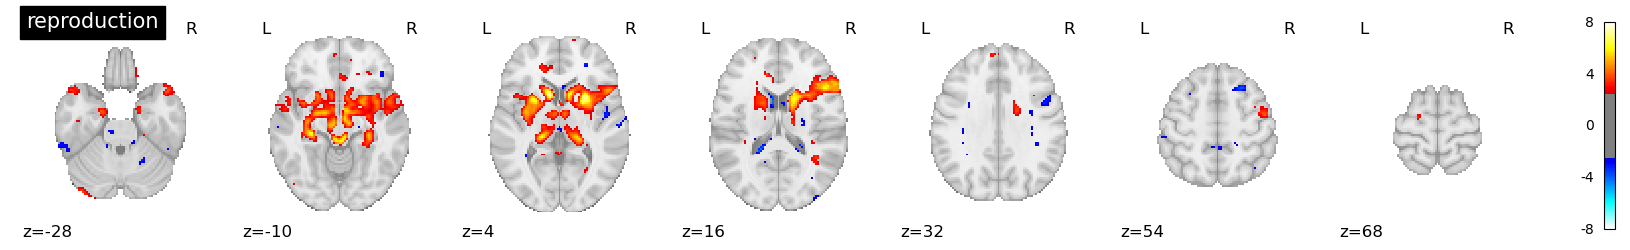

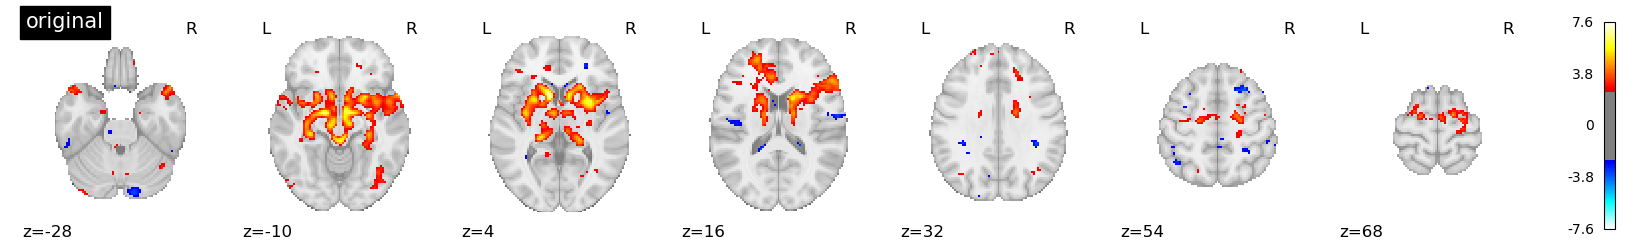

In [15]:
i_component_sorted = 0
i_component = i_components_sorted[i_component_sorted]
print(p_values.iloc[[i_component]])

cut_coords = [-28, -10, 4, 16, 32, 54, 68]
fig_ica_rep = plot_IC(fpath_ICs, i_component=i_component, cut_coords=cut_coords, title='reproduction')
fig_ica_ori = plot_IC("melodic_IC_0007.nii.gz", cut_coords=cut_coords, title='original')

## Process assessment scores

In [16]:
df_with_dbm = df_t1_info.loc[
    df_t1_info[COL_PAT_ID].isin(df_scores.index),
    [COL_PAT_ID, COL_STATUS],
].drop_duplicates()
print(df_with_dbm[COL_STATUS].value_counts())

Parkinson's Disease    238
Healthy Control        116
Name: COHORT_DEFINITION, dtype: int64


In [19]:
# cols_for_merge = [COL_PAT_ID, COL_VISIT_TYPE]
cols_for_merge = [COL_PAT_ID, COL_DATE_INFO, COL_VISIT_TYPE]

max_date_followup = MAX_DATES[VALIDATION_COHORT]

fpath_status = Path(utils.study_files_dir, FILENAME_PARTICIPANT_STATUS)
df_updrs1a = filter_date(load_ppmi_csv(utils, FILENAME_UPDRS1A), max_date=max_date_followup)
df_updrs1b = filter_date(load_ppmi_csv(utils, FILENAME_UPDRS1B), max_date=max_date_followup)
df_updrs2 = filter_date(load_ppmi_csv(utils, FILENAME_UPDRS2), max_date=max_date_followup)
df_updrs3 = filter_date(load_ppmi_csv(utils, FILENAME_UPDRS3), max_date=max_date_followup)
df_adl = filter_date(load_ppmi_csv(utils, FILENAME_ADL), max_date=max_date_followup)
df_moca = filter_date(load_ppmi_csv(utils, FILENAME_MOCA), max_date=max_date_followup)

df_age = load_ppmi_csv(utils, FILENAME_AGE)

df_updrs3 = df_updrs3.loc[df_updrs3[COL_PD_STATE] != "ON"]

df_assessments_all = reduce(
    lambda df1, df2: df1.merge(df2, on=cols_for_merge, how="outer"),
    [df_updrs1a, df_updrs1b, df_updrs2, df_updrs3, df_adl, df_moca],
).drop_duplicates()
print(f'All assessments merged: {df_assessments_all.shape}')

# keep only columns of interest
cols_keep = [
    COL_PAT_ID, COL_VISIT_TYPE, COL_DATE_INFO, 
    COL_MOCA, COL_ADL, COL_UPDRS1A, COL_UPDRS1B, COL_UPDRS2, COL_UPDRS3,
    # 'PDSTATE', 'PDTRTMNT',
]
df_assessments_all = df_assessments_all.loc[:, cols_keep]
df_assessments_all = mean_impute(
    df_assessments_all, 
    cols=[COL_ADL, COL_UPDRS1A, COL_UPDRS1B, COL_UPDRS2, COL_UPDRS3],
    fpath_status=fpath_status,
)

df_assessments_all[COL_STATUS] = df_status.set_index(COL_PAT_ID).loc[df_assessments_all[COL_PAT_ID], COL_STATUS].to_list()
df_assessments_all = df_assessments_all.merge(df_age, on=[COL_PAT_ID, COL_VISIT_TYPE], how='left')

df_assessments_all = df_assessments_all.loc[
    df_assessments_all[COL_PAT_ID].isin(df_with_dbm[COL_PAT_ID])
]
print(f'Keep subjects with DBM: {df_assessments_all.shape}')

df_assessments_all = df_assessments_all.loc[
    df_assessments_all[COL_STATUS] == STATUS_PD
]
print(f'Keep subjects with PD: {df_assessments_all.shape}')

df_assessments_baseline_tmp = df_assessments_all.loc[
    df_assessments_all[COL_VISIT_TYPE] == VISIT_BASELINE
]
print(f'Baseline: {df_assessments_baseline_tmp.shape}')
print(f'\tMax date: {df_assessments_baseline_tmp[COL_DATE_INFO].max()}')

df_assessments_followup = df_assessments_all.loc[
        (df_assessments_all[COL_PAT_ID].isin(df_assessments_baseline_tmp[COL_PAT_ID]))
        & (
            df_assessments_all[COL_VISIT_TYPE].apply(
                lambda v: re.match(REGEX_VISIT_FOLLOWUP, v)
            )
        )
        # & (~df_assessments_all[COL_UPDRS3].isna())
        # & (~df_assessments_all[COL_MOCA].isna())
    ]
df_assessments_followup = filter_date(
    df_assessments_followup, max_date=max_date_followup
)
df_assessments_followup = mean_impute(df_assessments_followup, cols=[COL_MOCA], within_visit=False, fpath_status=fpath_status)
print(f'Follow-ups: {df_assessments_followup.shape}')

df_assessments_followup = (
    df_assessments_followup.groupby(COL_PAT_ID)
    .apply(lambda df: df.sort_values(COL_DATE_INFO, ascending=False).head(1))
    .reset_index(drop=True)
)
print(f'Latest follow-up: {df_assessments_followup.shape}')

df_assessments_baseline_tmp = df_assessments_baseline_tmp.loc[
    df_assessments_baseline_tmp[COL_PAT_ID].isin(df_assessments_followup[COL_PAT_ID])
]
print(f'Baseline with followup: {df_assessments_baseline_tmp.shape}')

All assessments merged: (10054, 149)
Keep subjects with DBM: (3581, 11)
Keep subjects with PD: (2856, 11)
Baseline: (238, 11)
	Max date: 2013-05-01 00:00:00
Follow-ups: (1717, 11)
Latest follow-up: (227, 11)
Baseline with followup: (227, 11)


In [21]:
for timepoint, df in {'baseline': df_assessments_baseline_tmp, 'follow-up': df_assessments_followup}.items():
    print(f'===== MISSING DATA FOR: {timepoint.upper()} =====')
    print(df.isna().sum(axis='index') / len(df))

===== MISSING DATA FOR: BASELINE =====
PATNO                0.0
EVENT_ID             0.0
INFODT               0.0
MCATOT               1.0
MSEADLG              0.0
NP1RTOT              0.0
NP1PTOT              0.0
NP2PTOT              0.0
NP3TOT               0.0
COHORT_DEFINITION    0.0
AGE_AT_VISIT         0.0
dtype: float64
===== MISSING DATA FOR: FOLLOW-UP =====
PATNO                0.000000
EVENT_ID             0.000000
INFODT               0.000000
MCATOT               0.000000
MSEADLG              0.000000
NP1RTOT              0.000000
NP1PTOT              0.000000
NP2PTOT              0.000000
NP3TOT               0.000000
COHORT_DEFINITION    0.000000
AGE_AT_VISIT         0.004405
dtype: float64


Special handling of MoCA scores

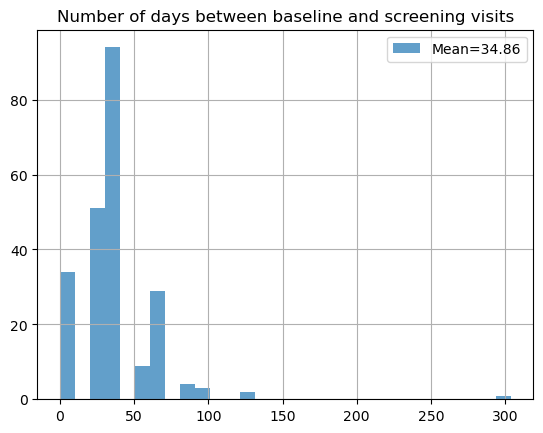

In [22]:
col_date_diff = "date_diff"

date_diffs = []

# get screening assessment data
df_assessments_screening = df_assessments_all.loc[
    df_assessments_all[COL_VISIT_TYPE] == VISIT_SCREENING
]

# try to fill in missing baseline data
df_assessments_baseline = df_assessments_baseline_tmp.copy()
for idx_row_baseline, row_baseline in df_assessments_baseline.iterrows():

    subject = row_baseline[COL_PAT_ID]
    date_baseline = row_baseline[COL_DATE_INFO]

    col = COL_MOCA

    # fill missing values with screening data
    if pd.isna(row_baseline[col]):

        df_screening_subject = df_assessments_screening.loc[
            df_assessments_screening[COL_PAT_ID] == subject
        ]

        # if a subject has multiple screening visits
        # sort them by how close they are to the baseline visit
        n_screening = len(df_screening_subject)
        if n_screening > 1:
            df_screening_subject[col_date_diff] = (
                date_baseline - df_screening_subject[COL_DATE_INFO]
            )
            df_screening_subject = df_screening_subject.sort_values(
                col_date_diff, ascending=True
            )

        # find corresponding assessment score in screening visits
        for idx_row_screening, row_screening in df_screening_subject.iterrows():
            new_value = row_screening[col]
            date_diff = date_baseline - row_screening[COL_DATE_INFO]
            if not pd.isna(new_value):
                break

        # replace
        if not pd.isna(new_value):
            df_assessments_baseline.loc[idx_row_baseline, col] = new_value
            date_diffs.append(date_diff.days)  # for plotting

# plot baseline-screening date difference
date_diffs = pd.Series(date_diffs)
ax = date_diffs.hist(
    bins=30, alpha=0.7, label=f"Mean={date_diffs.mean():.2f}"
)

# # NOTE: date resolution is months
ax.set_title("Number of days between baseline and screening visits")
ax.legend()

In [23]:
for timepoint, df in {'baseline': df_assessments_baseline, 'follow-up': df_assessments_followup}.items():
    print(f'===== MISSING DATA FOR: {timepoint.upper()} =====')
    print(df.isna().sum(axis='index') / len(df))

===== MISSING DATA FOR: BASELINE =====
PATNO                0.0
EVENT_ID             0.0
INFODT               0.0
MCATOT               0.0
MSEADLG              0.0
NP1RTOT              0.0
NP1PTOT              0.0
NP2PTOT              0.0
NP3TOT               0.0
COHORT_DEFINITION    0.0
AGE_AT_VISIT         0.0
dtype: float64
===== MISSING DATA FOR: FOLLOW-UP =====
PATNO                0.000000
EVENT_ID             0.000000
INFODT               0.000000
MCATOT               0.000000
MSEADLG              0.000000
NP1RTOT              0.000000
NP1PTOT              0.000000
NP2PTOT              0.000000
NP3TOT               0.000000
COHORT_DEFINITION    0.000000
AGE_AT_VISIT         0.004405
dtype: float64


In [219]:
# # impute remaning missing values
# cols_to_impute = [
#     COL_MOCA, COL_ADL, COL_UPDRS1A, COL_UPDRS1B, COL_UPDRS2, COL_UPDRS3,
# ]

# df_assessments_baseline = mean_impute(df_assessments_baseline, cols_to_impute)
# for visit_type in df_assessments_followup[COL_VISIT_TYPE].drop_duplicates():
#     idx_followup_visit = (df_assessments_followup[COL_VISIT_TYPE] == visit_type)
#     df_assessments_followup.loc[idx_followup_visit] = mean_impute(df_assessments_followup.loc[idx_followup_visit], cols_to_impute)

# for timepoint, df in {'baseline': df_assessments_baseline, 'follow-up': df_assessments_followup}.items():
#     print(f'===== MISSING DATA FOR: {timepoint.upper()} =====')
#     print(df.isna().sum(axis='index') / len(df))

===== MISSING DATA FOR: BASELINE =====
PATNO                0.0
EVENT_ID             0.0
INFODT               0.0
MCATOT               0.0
MSEADLG              0.0
NP1RTOT              0.0
NP1PTOT              0.0
NP2PTOT              0.0
NP3TOT               0.0
COHORT_DEFINITION    0.0
AGE_AT_VISIT         0.0
dtype: float64
===== MISSING DATA FOR: FOLLOW-UP =====
PATNO                0.000000
EVENT_ID             0.000000
INFODT               0.000000
MCATOT               0.295154
MSEADLG              0.000000
NP1RTOT              0.000000
NP1PTOT              0.000000
NP2PTOT              0.000000
NP3TOT               0.000000
COHORT_DEFINITION    0.000000
AGE_AT_VISIT         0.004405
dtype: float64


GCO

In [24]:
cols_for_gco = [
    COL_MOCA, COL_ADL, COL_UPDRS1A, COL_UPDRS1B, COL_UPDRS2, COL_UPDRS3,
]
df_for_gco_baseline = df_assessments_baseline[cols_for_gco]
gco_means = df_for_gco_baseline.mean()
gco_stds = df_for_gco_baseline.std()

for timepoint, df in {'baseline': df_assessments_baseline, 'follow-up': df_assessments_followup}.items():
    print(f'===== GCO FOR: {timepoint.upper()} =====')
    gco = ((df[cols_for_gco] - gco_means) / gco_stds).mean(
        axis="columns"
    )
    df[COL_GCO] = gco

    print(df[COL_GCO].mean())
    print(df[COL_GCO].std())

===== GCO FOR: BASELINE =====
-1.173804078898844e-16
0.4355553608011848
===== GCO FOR: FOLLOW-UP =====
0.40399770064410767
0.5744655939853484


In [25]:
threshold = 0.5

# only keep subjects with followup data
gco_baseline = df_assessments_baseline.set_index(COL_PAT_ID)[COL_GCO]
gco_baseline_std = gco_baseline.std()
print(f'Baseline SD: {gco_baseline_std}')

gco_followup = df_assessments_followup.set_index(COL_PAT_ID)[COL_GCO]

gco_thresholds = gco_baseline + threshold*gco_baseline_std

# gco_increase_binary = (gco_followup - gco_baseline >= threshold)
gco_increase_binary = gco_followup >= gco_thresholds
print('-'*20)
print(f'Increase by >= {threshold} SD:')
print(gco_increase_binary.value_counts(dropna=False))


Baseline SD: 0.4355553608011848
--------------------
Increase by >= 0.5 SD:
True     141
False     86
Name: GCO, dtype: int64


<Axes: >

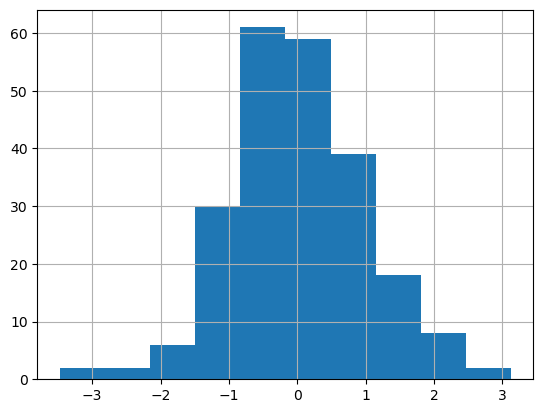

In [26]:
gco_diff = (gco_followup - gco_baseline)
((gco_diff - gco_diff.mean())/gco_diff.std()).hist()

In [27]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score

# cv = 10
cv = StratifiedKFold(10)

data_aucs = {}

for component in df_scores.columns:
    # i_component = 8
    # print(f'Using {component} to predict increase in GCO', end='')

    # keep subjects that didn't fail ICA
    subjects_keep = sorted(list(set(gco_increase_binary.index)))

    y = gco_increase_binary
    # X = pd.concat([df_scores.loc[subjects_keep].iloc[:, i_component], age_baseline], axis='columns')
    X = df_scores.loc[subjects_keep].loc[:, [component]]

    # regress out age
    age_baseline = df_assessments_baseline.set_index(COL_PAT_ID).loc[subjects_keep, COL_AGE]
    X_explained_by_age = LinearRegression().fit(X, age_baseline).predict(X).reshape(-1, 1)
    X -= X_explained_by_age

    # print(f'X: {X.shape}')
    # print(f'y: {y.shape}')

    y_pred = cross_val_predict(LogisticRegression(), X, y, cv=cv)

    auc = roc_auc_score(y, y_pred)
    data_aucs[component] = auc
    # print(f':\t{auc:.3f}')
    # break

aucs = pd.Series(data_aucs)
print(aucs.sort_values(ascending=False))

IC26    0.511628
IC3     0.508082
IC22    0.502969
IC9     0.500990
IC1     0.500000
IC15    0.500000
IC30    0.500000
IC27    0.500000
IC25    0.500000
IC21    0.500000
IC19    0.500000
IC18    0.500000
IC17    0.500000
IC31    0.500000
IC14    0.500000
IC7     0.500000
IC13    0.500000
IC12    0.500000
IC11    0.500000
IC4     0.500000
IC8     0.500000
IC5     0.500000
IC29    0.498722
IC28    0.496454
IC23    0.492908
IC24    0.492908
IC2     0.492908
IC16    0.492908
IC6     0.489362
IC20    0.489362
IC10    0.488083
dtype: float64


## OLD

In [122]:
# from livingpark_utils.scripts import mri_metadata

# df_status = load_ppmi_csv(utils, FILENAME_PARTICIPANT_STATUS)

# cohort_t1_map = {}
# for cohort_name in [MAIN_COHORT, VALIDATION_COHORT]:

#     print(f"=============== {cohort_name.capitalize()} cohort ===============")

#     df_t1_subset = get_t1_cohort(
#         utils,
#         cohort_name=cohort_name,
#         filename=FILENAME_T1_INFO,
#         sagittal_only=True,
#     )
#     cohort_t1_map[cohort_name] = df_t1_subset

#     # cohort composition: number of PD patients/healthy controls
#     print(
#         df_status.loc[
#             df_status[COL_PAT_ID].isin(df_t1_subset[COL_PAT_ID]), 
#             COL_STATUS,
#         ].value_counts()
#     )

=============== Main cohort ===============
Using MRI info file: /data/origami/livingpark/zeighami-etal-2019/inputs/study_files/MRI_info.csv
Parkinson's Disease    244
Healthy Control        117
Name: COHORT_DEFINITION, dtype: int64
=============== Validation cohort ===============
Using MRI info file: /data/origami/livingpark/zeighami-etal-2019/inputs/study_files/MRI_info.csv
Parkinson's Disease    161
Name: COHORT_DEFINITION, dtype: int64


### Remove subjects with no follow-up data available

The original paper excluded participants with less than 1 year of follow-up:
* 10 PD patients and 5 healthy controls from their main cohort
* No subjects were removed from the validation cohort

We will identify subjects with less than 1 year of follow-up for the PD progression measures.

First, we load/compute and merge all the required clinical/cognitive measures:
* UPDRS Part I
* UPDRS Part II
* UPDRS Part III
* Modified Schwab and England Activities of Daily Living (ADL) scale
* Postural instability and gait disturbance (PIGD) score
* MoCA

Missing values are imputed with the mean across the entire dataset, except for the MoCA score (handled below).

There are two files associated with UPDRS Part I (IA: Complex behaviors; IB: Partipant questionnaire). We use the sum of the total score in each file.

The PIGD score is defined in [Stebbins et al. 2013](https://doi.org/10.1002/mds.25383) and consists of the mean of a subset of UPDRS (Part II and III) measures.

In [51]:
# cols_for_merge = [COL_PAT_ID, COL_DATE_INFO, COL_VISIT_TYPE]

# df_updrs1a = load_ppmi_csv(utils, FILENAME_UPDRS1A, cols_to_impute=COL_UPDRS1A)
# df_updrs1b = load_ppmi_csv(utils, FILENAME_UPDRS1B, cols_to_impute=COL_UPDRS1B)
# df_updrs2 = load_ppmi_csv(
#     utils, FILENAME_UPDRS2, cols_to_impute=COLS_PIGD_COMPONENTS_UPDRS2 + [COL_UPDRS2]
# )
# df_updrs3 = load_ppmi_csv(
#     utils, FILENAME_UPDRS3, cols_to_impute=COLS_PIGD_COMPONENTS_UPDRS3 + [COL_UPDRS3]
# )
# df_adl = load_ppmi_csv(utils, FILENAME_ADL, cols_to_impute=COL_ADL)
# df_moca = load_ppmi_csv(utils, FILENAME_MOCA)  # do not impute

# df_updrs1 = df_updrs1a.merge(df_updrs1b, on=cols_for_merge)
# # df_updrs1[COL_UPDRS1] = df_updrs1.loc[:, [COL_UPDRS1B]].sum(axis="columns")
# df_updrs1[COL_UPDRS1] = df_updrs1.loc[:, [COL_UPDRS1A, COL_UPDRS1B]].sum(axis="columns")

# # some subjects in the validation cohort have multiple entries on the same date
# # one for PDSTATE=ON and one for PDSTATE=OFF
# # PDSTATE=OFF is the typical functional state when participants have a poor response in spite of taking medications
# # PDSTATE=ON is the typical functional state when patients are receiving medication and have a good response
# # we drop rows where PDSTATE is ON # TODO use cleaned table from notebook
# df_updrs3 = df_updrs3.loc[df_updrs3[COL_PD_STATE] != "ON"]

# # PIGD score is build from UPDRS (Stebbins et al. 2013)
# df_pigd = df_updrs2.merge(df_updrs3, on=cols_for_merge, how="inner")
# df_pigd[COL_PIGD] = df_pigd.loc[:, COLS_PIGD_COMPONENTS].mean(axis="columns")

# df_updrs1 = df_updrs1.loc[:, cols_for_merge + [COL_UPDRS1]]
# df_updrs2 = df_updrs2.loc[:, cols_for_merge + [COL_UPDRS2]]
# df_updrs3 = df_updrs3.loc[:, cols_for_merge + [COL_UPDRS3]]
# df_adl = df_adl.loc[:, cols_for_merge + [COL_ADL]]
# df_pigd = df_pigd.loc[:, cols_for_merge + [COL_PIGD]]
# df_moca = df_moca.loc[:, cols_for_merge + [COL_MOCA]]

# df_assessments_all = reduce(
#     lambda df1, df2: df1.merge(df2, on=cols_for_merge, how="outer"),
#     [df_updrs2, df_updrs3, df_adl, df_pigd, df_updrs1, df_moca],
# ).drop_duplicates()

# # some missing values remain even if we use the screening visit score
# # we will impute these using the original mean
# mean_moca = df_moca[COL_MOCA].mean()

# cols_to_impute = [col for col in COLS_SCORES_WITHOUT_GCO if col != COL_MOCA]
# df_assessments_all = mean_impute(df_assessments_all, cols_to_impute)

# # keep only subjects who have a T1
# cohort_assessments_map_orig: dict[str, pd.DataFrame] = {}
# for cohort_name, df_t1_subset in cohort_t1_map.items():
#     cohort_assessments_map_orig[cohort_name] = df_assessments_all.loc[
#         df_assessments_all[COL_PAT_ID].isin(df_t1_subset[COL_PAT_ID])
#     ]

Most subjects (including all subjects in the main cohort) took the MoCA during the screening visit, not the baseline visit. We replace the baseline MoCA score by the one from the screening visit. We plot a histogram for the number of days between baseline and screening visits, to check whether it was reasonable to use the screening visit score if the baseline score was not available.

========== MAIN COHORT ==========
Parkinson's Disease    242
Healthy Control        117
Name: COHORT_DEFINITION, dtype: int64
----- with followup -----
Parkinson's Disease    231
Healthy Control        113
Name: COHORT_DEFINITION, dtype: int64
========== VALIDATION COHORT ==========
Parkinson's Disease    161
Name: COHORT_DEFINITION, dtype: int64
----- with followup -----
Parkinson's Disease    137
Name: COHORT_DEFINITION, dtype: int64


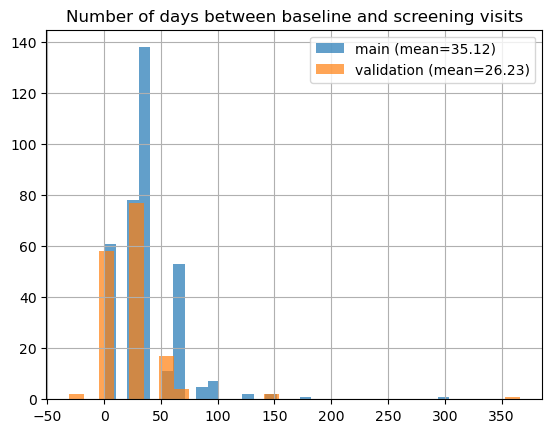

In [52]:
# col_date_diff = "date_diff"
# max_date_followup = MAX_DATES[VALIDATION_COHORT]

# re_followup_compiled = re.compile(REGEX_VISIT_FOLLOWUP)

# df_age = load_ppmi_csv(utils, FILENAME_AGE)
# COL_AGE = "AGE_AT_VISIT"

# cohort_assessments_map: dict[str, pd.DataFrame] = {}
# subjects_common_map: dict[str, set] = {}

# for cohort_name in cohort_assessments_map_orig:

#     print(f"========== {cohort_name.upper()} COHORT ==========")

#     date_diffs = []

#     # split baseline/screening assessment data
#     df_assessments_cohort: pd.DataFrame = cohort_assessments_map_orig[cohort_name]
#     df_assessments_baseline = df_assessments_cohort.loc[
#         df_assessments_cohort[COL_VISIT_TYPE] == VISIT_BASELINE
#     ]
#     df_assessments_screening = df_assessments_cohort.loc[
#         df_assessments_cohort[COL_VISIT_TYPE] == VISIT_SCREENING
#     ]

#     # try to fill in missing baseline data
#     for idx_row_baseline, row_baseline in df_assessments_baseline.iterrows():

#         subject = row_baseline[COL_PAT_ID]
#         date_baseline = row_baseline[COL_DATE_INFO]

#         # for each score columns
#         for col in [COL_MOCA]:

#             # fill missing values with screening data
#             if pd.isna(row_baseline[col]):

#                 df_screening_subject = df_assessments_screening.loc[
#                     df_assessments_screening[COL_PAT_ID] == subject
#                 ]

#                 # some subjects in validation set had multiple screening visits
#                 # in this case we sort them by how close they are to the baseline visit
#                 n_screening = len(df_screening_subject)
#                 if n_screening > 1:
#                     df_screening_subject[col_date_diff] = (
#                         date_baseline - df_screening_subject[COL_DATE_INFO]
#                     )
#                     df_screening_subject = df_screening_subject.sort_values(
#                         col_date_diff, ascending=True
#                     )

#                 # find corresponding assessment score in screening visits
#                 for idx_row_screening, row_screening in df_screening_subject.iterrows():
#                     new_value = row_screening[col]
#                     date_diff = date_baseline - row_screening[COL_DATE_INFO]
#                     if not pd.isna(new_value):
#                         break

#                 # replace
#                 if not pd.isna(new_value):
#                     df_assessments_baseline.loc[idx_row_baseline, col] = new_value
#                     date_diffs.append(date_diff.days)  # for plotting

#     # plot baseline-screening date difference
#     date_diffs = pd.Series(date_diffs)
#     ax = date_diffs.hist(
#         bins=30, alpha=0.7, label=f"{cohort_name} (mean={date_diffs.mean():.2f})"
#     )

#     # pick latest follow-up visit
#     df_assessments_followup = df_assessments_cohort.loc[
#         (df_assessments_cohort[COL_PAT_ID].isin(df_assessments_baseline[COL_PAT_ID]))
#         & (
#             df_assessments_cohort[COL_VISIT_TYPE].apply(
#                 lambda v: re_followup_compiled.match(v)
#             )
#         )
#     ]

#     # keep most recent follow-up data up to retrieval date in original paper
#     df_assessments_followup = filter_date(
#         df_assessments_followup, max_date=max_date_followup
#     )
#     df_assessments_followup = (
#         df_assessments_followup.groupby(COL_PAT_ID)
#         .apply(lambda df: df.sort_values(COL_DATE_INFO, ascending=False).head(1))
#         .reset_index(drop=True)
#     )

#     # we keep track of subjects who have both baseline and follow-up data
#     # TODO decide whether to drop subjects with no follow-up data for DBM part
#     # NOTE: for the DBM part, we don't drop subjects who don't have follow-up data,
#     #       but for the classification we will only use subjects with both baseline and follow-up data
#     subjects_common = set(df_assessments_cohort[COL_PAT_ID])
#     for df_visit in [df_assessments_baseline, df_assessments_followup]:
#         subjects_common = subjects_common & set(df_visit[COL_PAT_ID])
#     subjects_common_map[cohort_name] = subjects_common

#     # combine baseline and follow-up
#     df_assessments_baseline[COL_FOLLOWUP] = False
#     df_assessments_followup[COL_FOLLOWUP] = True
#     df_assessments_merged = pd.concat(
#         [df_assessments_baseline, df_assessments_followup], axis="index"
#     )

#     # add age
#     df_assessments_merged = df_assessments_merged.merge(
#         df_age, on=[COL_PAT_ID, COL_VISIT_TYPE], how='left',
#     )

#     # # only keep common subjects
#     # df_assessments_merged = df_assessments_merged.loc[
#     #     df_assessments_merged[COL_PAT_ID].isin(subjects_common)
#     # ]

#     # impute remaining missing MoCA values
#     df_assessments_merged.loc[
#         df_assessments_merged[COL_MOCA].isna(), COL_MOCA
#     ] = mean_moca

#     # add status
#     df_assessments_merged[COL_STATUS] = df_status.set_index(COL_PAT_ID).loc[df_assessments_merged[COL_PAT_ID], COL_STATUS].to_list()

#     print(df_assessments_merged.drop_duplicates(COL_PAT_ID)[COL_STATUS].value_counts())
#     print('----- with followup -----')
#     print(df_assessments_merged.loc[df_assessments_merged[COL_PAT_ID].isin(subjects_common)].drop_duplicates(COL_PAT_ID)[COL_STATUS].value_counts())

#     cohort_assessments_map[cohort_name] = df_assessments_merged

# # NOTE: date resolution is months
# ax.set_title("Number of days between baseline and screening visits")
# ax.legend()

### Final cohorts

We check the average time between baseline and follow-up visits. In the original paper they report an average of 4.5 years.

In [54]:
dfs_duration = []
for cohort_name, df_assessments_classification in cohort_assessments_map.items():
    dfs_duration.append(
        df_assessments_classification.loc[df_assessments_classification[COL_PAT_ID].isin(subjects_common_map[cohort_name])].groupby(COL_PAT_ID).apply(
            lambda df: (
                df.loc[df[COL_FOLLOWUP], COL_DATE_INFO].item()
                - df.loc[~df[COL_FOLLOWUP], COL_DATE_INFO].item()
            )
        )
    )

df_duration = pd.concat(dfs_duration)
print(
    f"{df_duration.mean().days / 365:.3f} "
    f"(\u00B1 {df_duration.std().days / 365:.3f}) years"
)

4.518 (± 1.230) years


Finally, we create a demographics table similar to the one in the original paper:

In [119]:
subjects_zeighami = pd.read_csv('/data/origami/livingpark/zeighami-etal-2019/dbm/ignore/data_elife/PPMI_DBM_for_JB/subject_IDs.csv')['ID']
print(subjects_zeighami.shape)

(349,)


In [120]:
def to_1_decimal_str(f):
    return str(round(f, 1))


df_age = load_ppmi_csv(utils, FILENAME_AGE)
df_demographics = load_ppmi_csv(utils, FILENAME_DEMOGRAPHICS)
df_pd_history = load_ppmi_csv(utils, FILENAME_PD_HISTORY)

col_male = "is_male"
col_cohort = "cohort"
col_age_diag = "age_diag"

dfs_summary = []
for cohort_name, df_assessments_classification in cohort_assessments_map.items():

    # only report subjects used in the classification
    subjects = df_assessments_classification.loc[
        # df_assessments_classification[COL_PAT_ID].isin(subjects_common_map[cohort_name]), 
        df_assessments_classification[COL_PAT_ID].isin(set(subjects_common_map[cohort_name]) & set(subjects_zeighami)), # TODO undo
        COL_PAT_ID
    ].drop_duplicates()
    subjects_pd = df_status.loc[
        (df_status[COL_PAT_ID].isin(subjects)) & (df_status[COL_STATUS] == STATUS_PD),
        COL_PAT_ID,
    ]

    # the paper only report measures for the PD patients
    df_assessments_classification = df_assessments_classification.loc[df_assessments_classification[COL_PAT_ID].isin(subjects_pd)]

    df_summary = df_demographics.merge(
        df_pd_history,
        on=[COL_PAT_ID],
    )
    df_summary[col_age_diag] = (
        df_summary[COL_DATE_PD] - df_summary[COL_DATE_BIRTH]
    ) / np.timedelta64(1, "Y")
    df_summary[col_male] = (df_summary[COL_SEX] == SEX_MALE).apply(
        lambda v: 100 if v else 0
    )
    df_summary = df_summary.loc[
        df_summary[COL_PAT_ID].isin(subjects_pd),
        [COL_PAT_ID, col_age_diag, col_male],
    ]
    df_summary[COL_FOLLOWUP] = False

    # combine with clinical/cognitive scores
    df_summary = df_summary.merge(
        df_assessments_classification, on=[COL_PAT_ID, COL_FOLLOWUP], how="outer"
    )
    df_summary = df_summary.drop(columns=COL_PAT_ID)

    # append
    df_summary[col_cohort] = f"{cohort_name} (n = {len(subjects_pd)})"
    dfs_summary.append(df_summary)

df_summary = pd.concat(dfs_summary)
df_summary_means = (
    df_summary.groupby([col_cohort, COL_FOLLOWUP]).mean().applymap(to_1_decimal_str)
)
df_summary_stds = (
    df_summary.groupby([col_cohort, COL_FOLLOWUP]).std().applymap(to_1_decimal_str)
)
df_summary_stds = " (" + df_summary_stds + ")"
df_summary_stds.loc[:, col_male] = ""
df_summary_combined = (df_summary_means + df_summary_stds).T
df_summary_combined = df_summary_combined.applymap(lambda x: "-" if "nan" in x else x)
df_summary_combined = df_summary_combined.drop(index=COL_AGE)
df_summary_combined = df_summary_combined.rename(
    index={
        col_age_diag: "Age at diagnosis",
        col_male: "Male (%)",
        COL_UPDRS2: "UPDRS Part II",
        COL_UPDRS3: "UPDRS Part III",
        COL_ADL: "S&E ADL",
        COL_PIGD: "PIGD",
        COL_UPDRS1: "UPDRS Part I",
        COL_MOCA: "MoCA",
        COL_GCO: "Global composite outcome",
    }
)
df_summary_combined

cohort                   main (n = 224)             
is_followup                       False        True 
Age at diagnosis             60.7 (9.1)            -
Male (%)                           64.3            -
UPDRS Part II                 5.7 (4.0)   10.8 (7.4)
UPDRS Part III               21.9 (9.2)  23.1 (12.0)
S&E ADL                      93.6 (5.7)  86.1 (11.9)
PIGD                          0.2 (0.2)    0.6 (0.6)
UPDRS Part I                  5.4 (3.9)    9.6 (6.2)
MoCA                         27.3 (2.2)   26.4 (3.3)
Global composite outcome      0.2 (0.4)    0.3 (0.6)

The values in the table above are generally similar to those obtained in the original paper, though not exactly the same. We were unable to obtain the same number of PD patients as the original paper: we have 223 instead of 222 for the main cohort, and 124 instead of 140 for the validation cohort. Our validation cohort has a smaller percentage of males (59.7%) compared to the original paper (67.9%). Mean clinical and cognitive assessment scores are generally close to those reported in the original paper, with some exceptions (e.g., UPDRS Parts I and III in the follow-up visits for both cohorts).

#### Cohort ID

We generate a cohort ID that uniquely identifies the main/validation cohorts. We will use these IDs to avoid recomputing the same results multiple times.

In [10]:
# cohort_ids = {}
# fpaths_cohort = {}
# for cohort_name, df_assessments_classification in cohort_assessments_map.items():

#     # get cohort ID
#     cohort_id = livingpark_utils.dataset.ppmi.cohort_id(
#         df_assessments_classification.drop_duplicates(COL_PAT_ID)
#     )
#     print(f"{cohort_name} cohort id: {cohort_id}")

#     df_t1 = cohort_t1_map[cohort_name]

#     # save patient ids
#     fpath_cohort = Path("dbm", f"zeighami-etal-2019-cohort-{cohort_id}.csv")
#     df_to_save = df_t1.loc[df_t1[COL_PAT_ID].isin(df_assessments_classification[COL_PAT_ID])]
#     df_to_save[COL_PAT_ID] = df_to_save[COL_PAT_ID].astype(np.int64)
#     df_to_save.drop_duplicates().sort_values(by=COL_PAT_ID).to_csv(
#         fpath_cohort, index=False
#     )
#     print(f"\tCohort patient ids saved in {fpath_cohort}")

#     cohort_ids[cohort_name] = cohort_id
#     fpaths_cohort[cohort_name] = fpath_cohort

# print("Do not share these files publicly!")

main cohort id: _460520092359662532
	Cohort patient ids saved in dbm/zeighami-etal-2019-cohort-_460520092359662532.csv
validation cohort id: _5930732793932369476
	Cohort patient ids saved in dbm/zeighami-etal-2019-cohort-_5930732793932369476.csv
Do not share these files publicly!


## PD progression classification

### Global composite outcome (GCO) measure

The global composite outcome is the average of the z-scores of the other measures. Following the original paper, we use the mean and standard deviation of the baseline session to compute the z-scores. 

In [115]:
df_assessments_classification = cohort_assessments_map[MAIN_COHORT].set_index(COL_PAT_ID)
print(f'Inital:\t\t{df_assessments_classification.shape}')

# only include PD patients
df_assessments_classification = df_assessments_classification.loc[
    df_assessments_classification[COL_STATUS] == STATUS_PD,
]
print(f'PD only:\t{df_assessments_classification.shape}')

# only include patients with followup
subjects_with_followup = df_assessments_classification.loc[
    df_assessments_classification[COL_FOLLOWUP],
].index
df_assessments_classification = df_assessments_classification.loc[subjects_with_followup]
print(f'With follow-up:\t{df_assessments_classification.shape}')

# only include patients with DBM
df_assessments_classification = df_assessments_classification.loc[
    df_assessments_classification.index.isin(df_scores.index)
]
print(f'Have DBM:\t{df_assessments_classification.shape}')

assert df_assessments_classification.reset_index().drop_duplicates(COL_PAT_ID).shape[0] == (df_assessments_classification.shape[0] // 2)

df_assessments_classification_baseline = df_assessments_classification.loc[
    ~df_assessments_classification[COL_FOLLOWUP], 
    COLS_SCORES_WITHOUT_GCO,
]
gco_means = df_assessments_classification_baseline.mean()
gco_stds = df_assessments_classification_baseline.std()
gco = ((df_assessments_classification[COLS_SCORES_WITHOUT_GCO] - gco_means) / gco_stds).mean(
    axis="columns"
)
df_assessments_classification[COL_GCO] = gco

print(df_assessments_classification[COL_GCO].mean())
print(df_assessments_classification[COL_GCO].std())

# df_assessments_classification

Inital:		(703, 12)
PD only:	(473, 12)
With follow-up:	(462, 12)
Have DBM:	(454, 12)
0.08161557654009305
0.5121604664696806


In [116]:
threshold = 0.5

# target variable is whether GCO increased by > 1.5SD from baseline
age_baseline = df_assessments_classification.loc[~df_assessments_classification[COL_FOLLOWUP], COL_AGE]
gco_baseline = df_assessments_classification.loc[~df_assessments_classification[COL_FOLLOWUP], COL_GCO]
gco_followup = df_assessments_classification.loc[df_assessments_classification[COL_FOLLOWUP], COL_GCO]

# only keep subjects with followup data
gco_baseline = gco_baseline.loc[gco_followup.index]
print(f'Baseline: {gco_baseline.shape}')
print(f'Followup: {gco_followup.shape}')
gco_baseline_std = gco_baseline.std()
print(f'Baseline SD: {gco_baseline_std}')

age_baseline = age_baseline.loc[gco_baseline.index]
print(f'Age: {age_baseline.shape}')

gco_thresholds = gco_baseline + threshold*gco_baseline_std

gco_increase_binary = (gco_followup >= gco_thresholds)
print('-'*20)
print(f'Increase by >= {threshold} SD:')
print(gco_increase_binary.value_counts(dropna=False))


Baseline: (227,)
Followup: (227,)
Baseline SD: 0.43038180139919296
Age: (227,)
--------------------
Increase by >= 0.5 SD:
False    128
True      99
Name: GCO, dtype: int64


<Axes: >

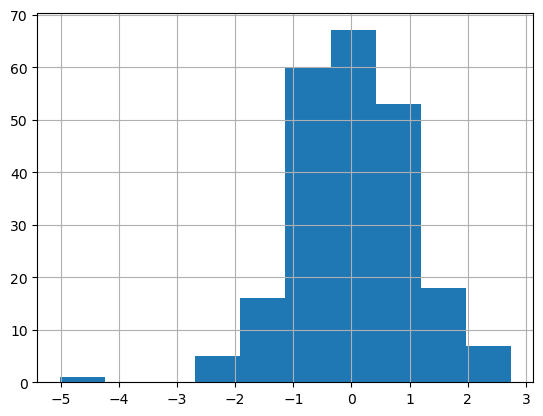

In [97]:
gco_diff = (gco_followup - gco_baseline)
((gco_diff - gco_diff.mean())/gco_diff.std()).hist()

In [112]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score

cv = 10
# cv = StratifiedKFold(10)

data_aucs = {}

for component in df_scores.columns:
    # i_component = 8
    # print(f'Using {component} to predict increase in GCO', end='')

    # keep subjects that didn't fail ICA
    subjects_keep = sorted(list(set(gco_increase_binary.index)))

    y = gco_increase_binary
    # X = pd.concat([df_scores.loc[y.index].iloc[:, i_component], age_baseline], axis='columns')
    X = df_scores.loc[y.index].loc[:, [component]]

    # regress out age
    X_explained_by_age = LinearRegression().fit(X, age_baseline).predict(X).reshape(-1, 1)
    X -= X_explained_by_age

    # print(f'X: {X.shape}')
    # print(f'y: {y.shape}')

    y_pred = cross_val_predict(LogisticRegression(), X, y, cv=cv)

    auc = roc_auc_score(y, y_pred)
    data_aucs[component] = auc
    # print(f':\t{auc:.3f}')
    # break

aucs = pd.Series(data_aucs)
print(aucs.sort_values(ascending=False))

IC6     0.554806
IC9     0.540325
IC5     0.514875
IC13    0.508483
IC8     0.505051
IC19    0.505051
IC28    0.502959
IC18    0.500671
IC4     0.500000
IC24    0.500000
IC30    0.500000
IC14    0.500000
IC15    0.500000
IC21    0.500000
IC17    0.500000
IC31    0.500000
IC29    0.496094
IC26    0.496094
IC1     0.496094
IC11    0.496094
IC7     0.493529
IC20    0.492188
IC2     0.492188
IC25    0.492188
IC22    0.491241
IC27    0.490096
IC12    0.489426
IC10    0.488281
IC3     0.485519
IC23    0.483902
IC16    0.483902
dtype: float64


# OLD

## Download DBM/ICA results from BIC server

Given the large number of subjects in our cohorts, it would be too computationally expensive to compute DBM maps from the notebook. Instead, we will use pre-computed results available from the BIC (the Montreal Neurological Institute's Brain Imaging Center) server.

The code for preprocessing the T1 images and computing the DBM maps is available in the `dbm_ica` directory of this repository. We attempted to follow the original paper's methods as closely possible, though software names and exact versions were not always specified. We implemented the DBM workflow using the MINC toolkit. For the ICA, we used FSL MELODIC to obtain z-statistic maps for each ICA component, as described in the original paper. The complete MRI processing workflow is summarized in the following diagrams:

| DBM pipeline                                        | ICA pipeline                                       |
| :-------------------------------------------------: | :------------------------------------------------: |
| <img src="images/dbm_minc_pipeline.svg" width=500/> | <img src="images/ica_fsl_pipeline.svg" width=400/> |

We used a Singularity container with the MINC toolkit `1.19.16`, FSL `5.0.11` (for the ICA), and some Python packages. The recipe file for this container is available in the `dbm_ica` directory.

**Prerequisites for getting the DBM/ICA results**
1. A BIC account
2. Set up SSH key authentication. There are plenty on online tutorials on how to do this, for example [here](https://www.digitalocean.com/community/tutorials/how-to-configure-ssh-key-based-authentication-on-a-linux-server).
    1. To login from your local machine (on which this notebook is running) to `login.bic.mni.mcgill.ca`
        - **Note**: If you decide to use a passphrase, make sure to use `ssh-add` to avoid being prompted for it when running the notebook. See [here](https://www.ssh.com/academy/ssh/agent#:~:text=The%20ssh%2Dagent%20is%20a,sign%2Don%20(SSO).) for instructions.
    2. To login from `login.bic.mni.mcgill.ca` to `ducky.bic-node.mni.mcgill.ca`
        - This is because we need `singularity`, which isn't available from `login.bic.mni.mcgill.ca`
        - ***IMPORTANT***: Do not use a passphrase here
3. Clone this repository on the BIC server in your home directory:
    ```
    >> cd ~
    >> git clone https://github.com/LivingPark-MRI/zeighami-etal-2019.git
    ```

In [11]:
# from pathlib import Path
# import re
# import subprocess


# def run_singularity_on_bic(
#     args: str,
#     fpath_container,
#     username,
#     dpaths_mount=None,
#     host="login.bic.mni.mcgill.ca",
# ):

#     if dpaths_mount is None:
#         dpaths_mount = []

#     components = [f"ssh {username}@{host} ssh ducky nice -n 10 singularity run"]

#     for dpath_mount in dpaths_mount:
#         components.append(f"--bind {dpath_mount}:{dpath_mount}")

#     components.append(fpath_container)
#     components.append(args)

#     components = [str(component) for component in components if component != ""]
#     # print(' '.join(components))
#     components = (" ".join(components)).split()  # split on whitespace

#     # ssh to BIC and run command
#     return subprocess.run(components, capture_output=True)


# # TODO store username in file
# def check_result_availability(
#     cohort_id,
#     cohort_file,
#     dpath_repo,
#     dpath_outputs="outputs",
#     fpath_container_rel="dbm_ica/nd-minc_1_9_16-fsl_5_0_11-click_livingpark_pandas_pybids.sif",
#     dpath_bids=None,
#     dpath_out_dbm=None,
#     username=None,
#     host="login.bic.mni.mcgill.ca",
#     varname_dpath_ica="DPATH_ICA_RESULTS",
#     varname_cohort_id="FINAL_COHORT_ID",
#     varname_fpath_proc_status="FPATH_PROC_STATUS_COHORT",
#     varname_fpath_dbm_list="FPATH_DBM_LIST_COHORT",
# ):
#     def run_scp(source, dest, from_remote=False):
#         if from_remote:
#             source = f"{username}@{host}:{source}"
#         else:
#             dest = f"{username}@{host}:{dest}"
#         args = [
#             "scp",
#             "-r",
#             source,
#             dest,
#         ]
#         subprocess.run(args)

#     def get_var(name, output, sep="=", end="\n"):
#         match = re.search(f"{name}{sep}(.*){end}", output)
#         if not match or len(match.groups()) != 1:
#             raise RuntimeError(f"Did not find name in command output")
#         return match.groups()[0]

#     # TODO first check if results are already available locally
#     # NOTE: cohort IDs might be different, in that case we will have to run things on the BIC server

#     if username is None:
#         username = input("Please enter your BIC username: ")

#     dpaths_mount = [
#         dpath for dpath in [dpath_repo, dpath_bids, dpath_out_dbm] if dpath is not None
#     ]

#     dpath_repo = Path(dpath_repo)
#     fpath_container = dpath_repo / fpath_container_rel
#     fpath_script = dpath_repo / "dbm_ica" / "check_results_availability.sh"

#     # copy cohort file to BIC
#     run_scp(cohort_file, dpath_repo, from_remote=False)

#     completed = run_singularity_on_bic(
#         args=f"{fpath_script} {cohort_id}",
#         fpath_container=fpath_container,
#         dpaths_mount=dpaths_mount,
#         username=username,
#         host=host,
#     )
#     output = completed.stdout.decode("utf-8")
#     print(output)

#     if completed.returncode != 0:
#         error = completed.stderr.decode("utf-8")
#         print(f"STDERR:\n{error}")
#         raise RuntimeError(
#             f"Error running script on BIC (returned {completed.returncode})"
#         )

#     # parse output
#     dpath_results_remote = get_var(varname_dpath_ica, output)
#     final_cohort_id = get_var(varname_cohort_id, output)
#     fpath_proc_status_remote = get_var(varname_fpath_proc_status, output)
#     fpath_dbm_list_remote = get_var(varname_fpath_dbm_list, output)

#     # copy ICA results from BIC
#     dpath_results_local = Path(dpath_outputs) / Path(dpath_results_remote).name
#     fpath_proc_status_local = (
#         Path(dpath_results_local) / Path(fpath_proc_status_remote).name
#     )
#     fpath_dbm_list_local = Path(dpath_results_local) / Path(fpath_dbm_list_remote).name

#     if fpath_dbm_list_local.exists():
#         print("ICA results have already been downloaded, skipping scp")
#     else:
#         run_scp(dpath_results_remote, dpath_results_local, from_remote=True)

#     return (
#         final_cohort_id,
#         dpath_results_local,
#         fpath_proc_status_local,
#         fpath_dbm_list_local,
#     )

We download ICA results for the main cohort. If the DBM maps are available but the ICA results are not, this will compute the ICA (which could take a few hours), and it might be necessary to rerun this cell once the ICA is done.

In [12]:
# _, dpath_outputs, _, _ = check_result_availability(
#     cohort_id=cohort_ids[MAIN_COHORT],
#     cohort_file=f"zeighami-etal-2019-cohort-{cohort_ids[MAIN_COHORT]}.csv",
#     dpath_repo="/data/origami/livingpark/zeighami-etal-2019/",
# )

We load the scores (average DBM value for each ICA component for each subject) and split them into a PD group and a healthy control group:

In [13]:
# df_scores = pd.read_csv(dpath_outputs / "scores.csv", index_col=0)
# df_scores.index = df_status.set_index(COL_PAT_ID).loc[
#     df_scores.index.astype(np.int64), COL_STATUS
# ]
# df_scores.index.value_counts()

As in the original study, we use t-tests to determine whether any component is significantly different between the two groups. We apply Bonferonni correction to the p-values to account for multiple comparisons.

In [14]:
# from scipy.stats import ttest_ind

# correct = True
# p_values_data = {}

# for component in df_scores.columns:
#     t_stat, p = ttest_ind(
#         df_scores.loc[STATUS_PD, component],
#         df_scores.loc[STATUS_HC, component],
#     )
#     p_values_data[component] = p

# p_values = pd.Series(p_values_data)

# if correct:
#     p_values = p_values * len(p_values)  # Bonferroni correction

# i_components_sorted = np.argsort(list(p_values))
# i_component_top = i_components_sorted[0]

# p_values.sort_values()

We plot the DBM score distributions for each IC:

In [15]:
# import seaborn as sns

# x_label = "IC"
# y_label = "Mean DBM value"

# df_scores_to_plot = pd.melt(
#     df_scores.reset_index(),
#     id_vars=[COL_STATUS],
#     var_name=x_label,
#     value_name=y_label,
# )

# ax = sns.stripplot(
#     df_scores_to_plot,
#     x=x_label,
#     y=y_label,
#     hue=COL_STATUS,
#     order=p_values.sort_values().index,
#     alpha=0.4,
# )
# ax.tick_params(axis="x", rotation=90)

None of the corrected p-values reach significance: our lowest p-value is 3.37 compared to 0.003 in the original paper. This means that our replication has failed at this stage, since we are unable to obtain the PD-ICA component presented in the original paper. 

Our top ICA component looks like this:

In [16]:
import nibabel as nib
from nilearn import image, plotting


def plot_IC(fpath, i_component=None, threshold=3, display_mode="z"):
    img = nib.load(fpath)
    if i_component is not None:
        img = image.index_img(img, i_component)
    display = plotting.plot_stat_map(
        img, threshold=threshold, display_mode=display_mode
    )
    return display

In [17]:
# fig_IC = plot_IC(
#     dpath_outputs / "melodic_results" / "melodic_IC.nii.gz",
#     i_component=i_components_sorted[0],
# )

We compare our top ICA component with the PD-ICA component from the original paper (available [here](https://identifiers.org/neurovault.image:12551)):

In [18]:
%%bash
FNAME_PD_ICA="melodic_IC_0007.nii.gz"
if [ ! -f ${FNAME_PD_ICA} ]
then
    wget "https://neurovault.org/media/images/860/${FNAME_PD_ICA}"
else
    echo 'ICA file already exists, skipping download'
fi

ICA file already exists, skipping download


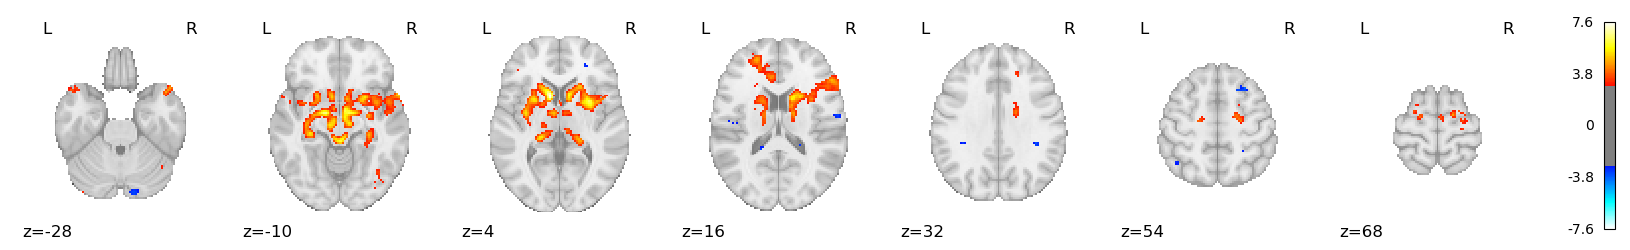

In [19]:
fig_IC_orig = plot_IC("melodic_IC_0007.nii.gz")

Our most significant component does not match the PD-ICA component described in the original study: we obtain regions mostly in the frontal lobe, while the original ICA component mainly includes subcortical regions. Moreover, our clusters tend to be bigger than those in the PD-ICA component, suggesting that there could be inconsistencies in spatial smoothing procedures between our pipeline and the one used in the original study. 